<a href="https://colab.research.google.com/github/peteray-dev/GAN_Painter/blob/master/I_AM_SOMETHING_OF_A_PAINTER_MYSELF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')


In [6]:

!kaggle competitions download gan-getting-started


100% 367M/367M [00:05<00:00, 36.4MB/s]
100% 367M/367M [00:05<00:00, 64.9MB/s]


In [7]:
!mkdir gan-getting-started.zip

!mv /content/gan-getting-started.zip* /content/gan-getting-started

mkdir: cannot create directory ‘gan-getting-started.zip’: File exists


 **GAN PROCESS**

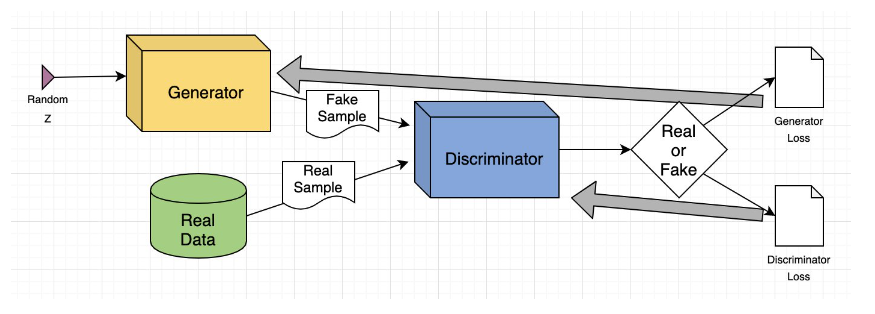

In [12]:
! unzip "/content/gan-getting-started/gan-getting-started.zip"

Streaming output truncated to the last 5000 lines.
  inflating: photo_jpg/46e71a4094.jpg  
  inflating: photo_jpg/46e84039a1.jpg  
  inflating: photo_jpg/46f391abec.jpg  
  inflating: photo_jpg/46f5ef1042.jpg  
  inflating: photo_jpg/4706619607.jpg  
  inflating: photo_jpg/4707b03a08.jpg  
  inflating: photo_jpg/47100a9939.jpg  
  inflating: photo_jpg/471f4755b9.jpg  
  inflating: photo_jpg/472b351bc4.jpg  
  inflating: photo_jpg/472d5ac100.jpg  
  inflating: photo_jpg/4758e5dd4c.jpg  
  inflating: photo_jpg/4762bb79ef.jpg  
  inflating: photo_jpg/4778b13518.jpg  
  inflating: photo_jpg/4787b82d37.jpg  
  inflating: photo_jpg/478e07feaa.jpg  
  inflating: photo_jpg/478eb12a82.jpg  
  inflating: photo_jpg/479698b371.jpg  
  inflating: photo_jpg/4796d67f61.jpg  
  inflating: photo_jpg/47aad493bd.jpg  
  inflating: photo_jpg/47ae0edd23.jpg  
  inflating: photo_jpg/47b94957ff.jpg  
  inflating: photo_jpg/47bb43fe3e.jpg  
  inflating: photo_jpg/47bb59d449.jpg  
  inflating: photo_jpg/47d391

In [53]:
# Import necessary packages.
import numpy as np
import cv2
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Subset, Dataset

import torchvision
from torchvision import datasets
from torchvision.datasets import DatasetFolder
import torchvision.transforms as transforms


# This is for the progress bar.
from tqdm.auto import tqdm
# This is for ploting
import matplotlib.pyplot as plt

In [14]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_paths = [os.path.join(img_dir, img_name) for img_name in os.listdir(img_dir) if img_name.endswith(('png', 'jpg', 'jpeg'))]

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

# Example usage
transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.ToTensor()
])

monet_dataset = CustomImageDataset(img_dir="/content/monet_jpg", transform=transform)
photo_dataset = CustomImageDataset(img_dir="/content/photo_jpg", transform=transform)

In [15]:
monet_dataset[0].shape

torch.Size([3, 256, 256])

In [16]:
print(f"Monet dataset: {len(monet_dataset)}")
print(f"photo dataset: {len(photo_dataset)}")

Monet dataset: 300
photo dataset: 7038


In [17]:
monet_loader = DataLoader(monet_dataset, batch_size=32, shuffle=True)
photo_loader = DataLoader(photo_dataset, batch_size=32, shuffle=True)

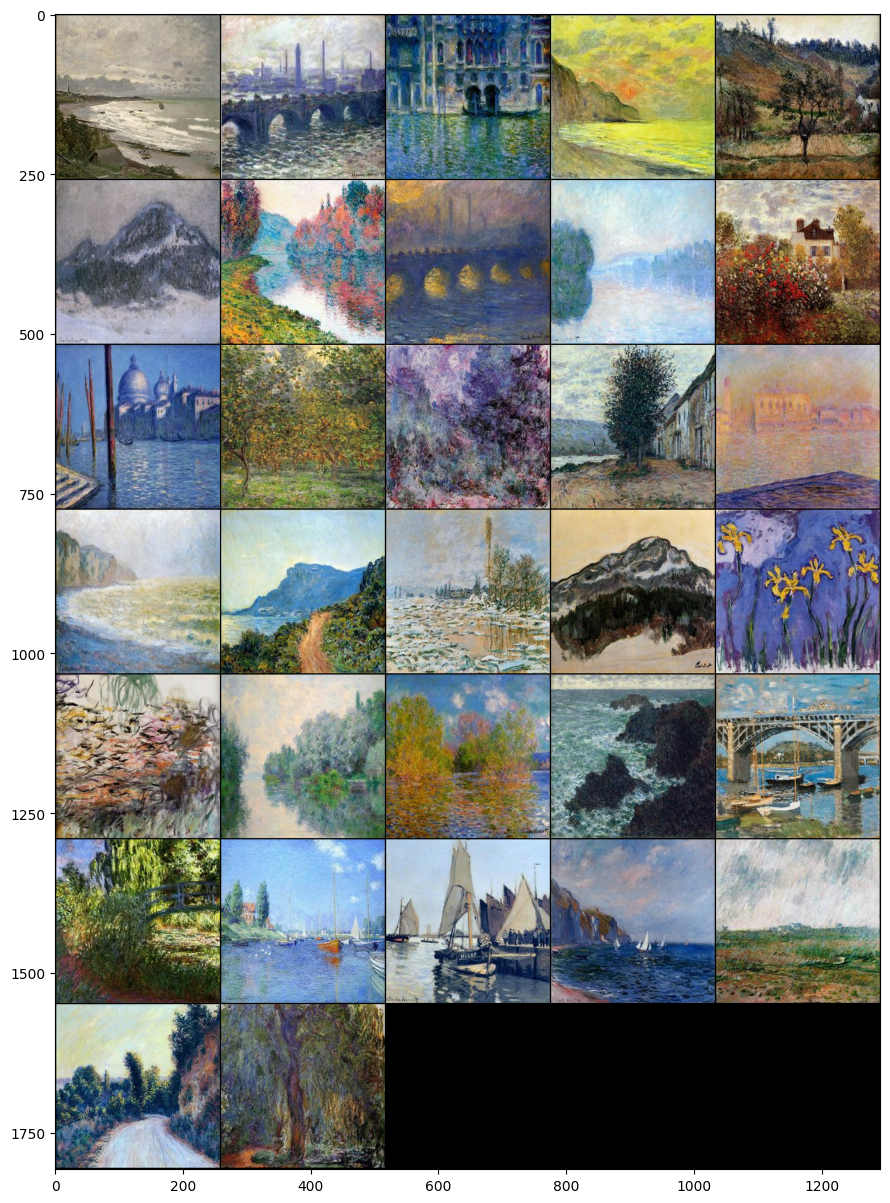

In [18]:
def show_image(image, title=None):
    """Show image with title if provided."""
    image = image.numpy().transpose((1, 2, 0))
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.pause(0.001)
# Get a batch of training data
data_iter = iter(monet_loader)
images = next(data_iter)

# Make a grid from batch
out = torchvision.utils.make_grid(images, nrow=5)

# Display the images
plt.figure(figsize=(15, 15))  # Adjust figure size as needed
show_image(out)
plt.show()


In [55]:
shape = cv2.imread('/content/monet_jpg/011835cfbf.jpg').shape
shape

(256, 256, 3)

## Model Building

Generator (Upsampling)

In [42]:

class Generator(nn.Module):
    def __init__(self, latent_dim, img_channels, feature_maps_g):
        super(Generator, self).__init__()

        self.init_size = 7  # Initial size before upsampling
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, feature_maps_g * 8 * self.init_size * self.init_size)
        )

        self.deconv_layers = nn.Sequential(
            nn.BatchNorm2d(feature_maps_g * 8),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(feature_maps_g * 8, feature_maps_g * 4, 3, stride=1, padding=1),
            nn.BatchNorm2d(feature_maps_g * 4),
            nn.ReLU(True),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(feature_maps_g * 4, feature_maps_g * 2, 3, stride=1, padding=1),
            nn.BatchNorm2d(feature_maps_g * 2),
            nn.ReLU(True),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(feature_maps_g * 2, feature_maps_g, 3, stride=1, padding=1),
            nn.BatchNorm2d(feature_maps_g),
            nn.ReLU(True),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(feature_maps_g, img_channels, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        out = self.fc(z)
        out = out.view(out.size(0), -1, self.init_size, self.init_size) #(batch_size =32, feature_maps_g * 8=256, 16, 16)
        img = self.deconv_layers(out)
        return img

latent_dim = 100
img_channels = 3
feature_maps_g = 32

gen = Generator(latent_dim, img_channels, feature_maps_g)
print(gen)


Generator(
  (fc): Sequential(
    (0): Linear(in_features=100, out_features=12544, bias=True)
  )
  (deconv_layers): Sequential(
    (0): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode='nearest')
    (2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Upsample(scale_factor=2.0, mode='nearest')
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Upsample(scale_factor=2.0, mode='nearest')
    (10): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): Upsample(scale_factor=2.0, mode

Discriminator (Downsampling)

In [43]:
class Discriminator(nn.Module):
    def __init__(self, img_channels, feature_maps_d):
        super(Discriminator, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(img_channels, feature_maps_d, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_maps_d, feature_maps_d * 2, 4, stride=2, padding=1),
            nn.BatchNorm2d(feature_maps_d * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_maps_d * 2, feature_maps_d * 4, 4, stride=2, padding=1),
            nn.BatchNorm2d(feature_maps_d * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_maps_d * 4, feature_maps_d * 8, 4, stride=2, padding=1),
            nn.BatchNorm2d(feature_maps_d * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_maps_d * 8, 1, 4, stride=1, padding=0),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Sigmoid()
        )


    def forward(self, img):
        validity = self.conv_layers(img)
        return validity.view(img.size(0), -1)

img_channels = 3
feature_maps_d = 32

disc = Discriminator(img_channels, feature_maps_d)
print(disc)


Discriminator(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1))
    (12): AdaptiveAvgPool2d(output_size=(1, 1))
    (13): Sigmoid()
  )
)


In [81]:
photo = next(iter(photo_loader))
photo[0].shape

torch.Size([3, 256, 256])

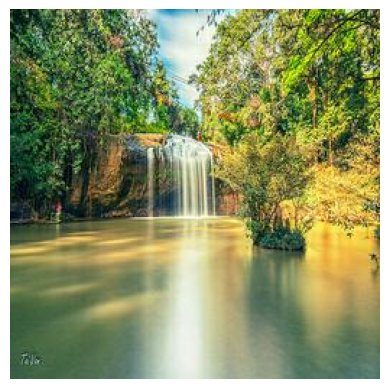

In [84]:
import matplotlib.pyplot as plt

# Assuming `real_images` is your tensor
real_images = next(iter(photo_loader))

# Visualize the first image in the batch
plt.imshow(real_images[0].permute(1, 2, 0))  # since the images are in format (C, H, W)
plt.axis('off')  # Hide axes
plt.show()



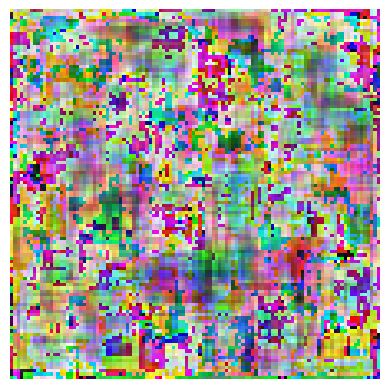

In [91]:

# Create the generator
gen = Generator(100, 3, 32)

# Sample noise vector
noise_vector = torch.randn(1, latent_dim)

# Generate an image
with torch.no_grad():
    generated_image = gen(noise_vector)

def visualize_images(generated_imgs=None):
    """
    Visualizes the generated images.
    """
    generated_img = transforms.ToPILImage()(generated_imgs.squeeze(0))  # Assuming generated image
    plt.imshow(generated_img)
    plt.axis('off')  # Hide axes
    plt.show()


visualize_images(generated_image)


In [89]:

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
    print("GPU Device Name:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available")

GPU is available
GPU Device Name: Tesla T4


In [45]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"



In [46]:
# Initialize a model, and put it on the device specified.
gen = Generator(latent_dim, img_channels, feature_maps_g)
dis = Discriminator(img_channels, feature_maps_d)
gen = gen.to(device)
dis = dis.to(device)

### Optimizer and Loss

In [47]:
# Loss function
adversarial_loss = nn.BCELoss()

# Optimizers
optimizer_G = torch.optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(dis.parameters(), lr=0.0002, betas=(0.5, 0.999))


### Training

In [48]:
for data in photo_loader:
    print(data.size(0))  # Print the number of elements returned
    break

32


In [61]:
num_epochs = 10
# Training loop
for epoch in range(num_epochs):
    for i, imgs in enumerate(tqdm(photo_loader)):

        # Adversarial ground truths
        valid = torch.ones(imgs.size(0), 1, requires_grad=False).to(device)
        fake = torch.zeros(imgs.size(0), 1, requires_grad=False).to(device)

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = torch.randn(imgs.size(0), latent_dim).to(device)
        # print(imgs.size(0))
        # Generate a batch of images
        gen_imgs = gen(z)
        # print(gen_imgs.size())
        # print(dis(gen_imgs).size())
        # print(valid.size())
        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(dis(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(dis(imgs.to(device)), valid)
        fake_loss = adversarial_loss(dis(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

    print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(photo_loader)}] [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")


  0%|          | 0/220 [00:00<?, ?it/s]

32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32


KeyboardInterrupt: 

In [72]:
generated_image

tensor([[[[-0.1914, -0.1625, -0.0883,  ..., -0.3569, -0.2825, -0.1708],
          [-0.1883, -0.3896, -0.3385,  ..., -0.4676, -0.3221, -0.4050],
          [-0.1922, -0.4225, -0.2523,  ..., -0.5509, -0.3855, -0.3761],
          ...,
          [ 0.0236, -0.1108, -0.3518,  ..., -0.3304, -0.2928, -0.4384],
          [-0.0180, -0.1755, -0.3327,  ..., -0.4605, -0.3184, -0.4466],
          [-0.2745, -0.3970, -0.3869,  ..., -0.4648, -0.4231, -0.4786]],

         [[-0.2042, -0.0971, -0.0557,  ..., -0.1517,  0.0115,  0.0927],
          [-0.2222, -0.1713, -0.0741,  ..., -0.1255, -0.1013, -0.0377],
          [-0.2049, -0.3880, -0.2837,  ..., -0.2467, -0.2222, -0.1323],
          ...,
          [ 0.1132, -0.0081, -0.0718,  ...,  0.3874,  0.2624, -0.0355],
          [-0.0151,  0.1147,  0.1240,  ...,  0.2176,  0.1704,  0.0128],
          [-0.1121,  0.1225,  0.1705,  ..., -0.0104,  0.0520, -0.0794]],

         [[-0.1723, -0.4338, -0.4346,  ..., -0.3146, -0.1594, -0.1954],
          [-0.2068, -0.1075, -